# SimCLR with MNIST
A little ML nugget to reproduce the [SimCLR paper](https://arxiv.org/abs/2002.05709). We'll be using MNIST again here.

![simclr](https://amitness.com/posts/images/simclr-general-architecture.png)

Sim CLR (ka A Simple Framework for Contrastive Learning of Visual Representations) uses **self-supervised learning** to learn useful representations without any labels, using only augmented views of the input image.

- **Contrastive Learning Objective**:
  - Bring **positive pairs** (two augmentations of the same image) closer in the embedding space.
  - Push **negative pairs** (augmentations from different images)  apart.

- **Ingredients**:
  - **Data Augmentation**: Each image is randomly augmented **twice** (crop, flip, color jitter, etc.).
  - **Encoder Network**: A CNN (e.g., ResNet or ConvNet) maps images to feature vectors.
  - **Projection Head**: A small MLP maps features to a space where contrastive loss is applied.
  - **Contrastive Loss**: NT-Xent loss (Normalized Temperature-scaled Cross Entropy) encourages similar pairs to be close.

- **Training part**:
  - No labels needed during contrastive training.
  - After training, the encoder is used as a feature extractor.
  - A linear classifier can be trained on top of frozen features for downstream tasks (e.g., classification).

---

The goal of the paper was to show that **good augmentations + contrastive loss + projection head** can produce powerful representations,neural embeddings, even without labeled data. It's a foundational idea in modern self-supervised learning used for instance for transformers!!


# Preparing our augmentations
Wonder what they are, Google them! Important is: we want the output to be invariant to the transformation as much as possible (cat with sunglasses is also a cat, remember?)

In [15]:
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# ----- Data Augmentation -----
class SimCLRPreprocessing(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
        self.augment = tf.keras.Sequential([
            layers.Rescaling(1./255),
            layers.RandomCrop(28, 28),
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(0.1),
            layers.RandomZoom(0.2),
        ])

    def call(self, x):
        return self.augment(x), self.augment(x)


# Make the encoder and projection head to z (where we do the cosine similarity)

In [ ]:

# ----- Encoder and Projection Head -----
def create_encoder(projection_dim=32):
    base_model = tf.keras.Sequential([
        layers.Conv2D(32, 3, strides=2, activation='relu'),
        layers.Conv2D(64, 3, strides=2, activation='relu'),
        layers.GlobalAveragePooling2D(),
    ])
    inputs = tf.keras.Input(shape=(28, 28, 1))
    features = base_model(inputs)
    outputs = tf.keras.Sequential([
        layers.Dense(64, activation='relu'),
        layers.Dense(projection_dim)
    ])(features)
    outputs = tf.math.l2_normalize(outputs, axis=1)
    return tf.keras.Model(inputs, outputs)

# Then the contrastive loss

In [ ]:
# This is complicated, let's imolement NT-Xent
def contrastive_loss(z1, z2, temperature=0.5):
    # First: Concatenate both batches of embeddings (positive pairs)
    z = tf.concat([z1, z2], axis=0)  # shape: (2N, D), where N is batch size

    # Step 2: Compute cosine similarity matrix between all embeddings
    sim = tf.matmul(z, z, transpose_b=True)  # shape: (2N, 2N), sim[i][j] = similarity between sample i and j
    sim /= temperature  # scale similarities by temperature (sharpening)

    # Step 3: Create labels — position i matches with i + N ( same image, different view)
    batch_size = tf.shape(z1)[0]
    labels = tf.range(batch_size)
    labels = tf.concat([labels, labels], axis=0)  # shape: (2N,)

    # Step 4: Remove self-similarities (diagonal) from similarity matrix
    mask = tf.eye(2 * batch_size)  # identity matrix
    sim = sim - 1e9 * mask  # set diagonal to a large negative number so it's ignored in softmax, HACKY! COuld do masking but expensive

    # Step 5: Extract positive similarities from the similarity matrix
    # Positive pairs are offset by +N and -N in the 2N batch
    positives = tf.concat([
        tf.linalg.diag_part(sim, k=batch_size),   # sim[i][i+N]
        tf.linalg.diag_part(sim, k=-batch_size)   # sim[i+N][i]
    ], axis=0)  # shape: (2N,)

    # Step 6: Compute NT-Xent loss
    numerator = tf.exp(positives)  # exp(similarity of positive pairs)
    denominator = tf.reduce_sum(tf.exp(sim), axis=1)  # sum over all other similarities for each sample
    loss = -tf.math.log(numerator / denominator)  # -log(positive / all)
    
    # Step 7: Return average loss over the batch
    return tf.reduce_mean(loss)


# Fetch data and train

In [ ]:

# ----- Data -----
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train[..., tf.newaxis].astype("float32")#→ (N, 28, 28, 1), a different way of adding a channel
x_test = x_test[..., tf.newaxis].astype("float32")#→ (N, 28, 28, 1)

batch_size = 512
augment = SimCLRPreprocessing()
train_ds = (
    tf.data.Dataset.from_tensor_slices(x_train)
    .shuffle(1024)
    .map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)
#Returns: 
# x1: (batch_size, 28, 28, 1), x2: (batch_size, 28, 28, 1) --> Only augmented images, not the initial image!

# ----- Train SimCLR Encoder -----
model = create_encoder()
optimizer = tf.keras.optimizers.Adam()

for epoch in range(20):
    losses = []
    for x1, x2 in train_ds:
        with tf.GradientTape() as tape:
            z1 = model(x1, training=True)
            z2 = model(x2, training=True)
            loss = contrastive_loss(z1, z2)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        losses.append(loss.numpy())
    print(f"Epoch {epoch+1}: Loss = {np.mean(losses):.4f}")

Epoch 1: Loss = 6.0676
Epoch 2: Loss = 5.8034
Epoch 3: Loss = 5.7030
Epoch 4: Loss = 5.6515
Epoch 5: Loss = 5.6122
Epoch 6: Loss = 5.5976
Epoch 7: Loss = 5.5693
Epoch 8: Loss = 5.5413
Epoch 9: Loss = 5.5144
Epoch 10: Loss = 5.4987
Epoch 11: Loss = 5.4863
Epoch 12: Loss = 5.4783
Epoch 13: Loss = 5.4688
Epoch 14: Loss = 5.4560
Epoch 15: Loss = 5.4482
Epoch 16: Loss = 5.4436
Epoch 17: Loss = 5.4317
Epoch 18: Loss = 5.4313
Epoch 19: Loss = 5.4230
Epoch 20: Loss = 5.4166


# Cool! We made our first embedding. 

# Let's use t-SNE to vizualize the embedding
We haven't trained with any labels, is our model still able to tell the numbers apart, although trained unsupervised?

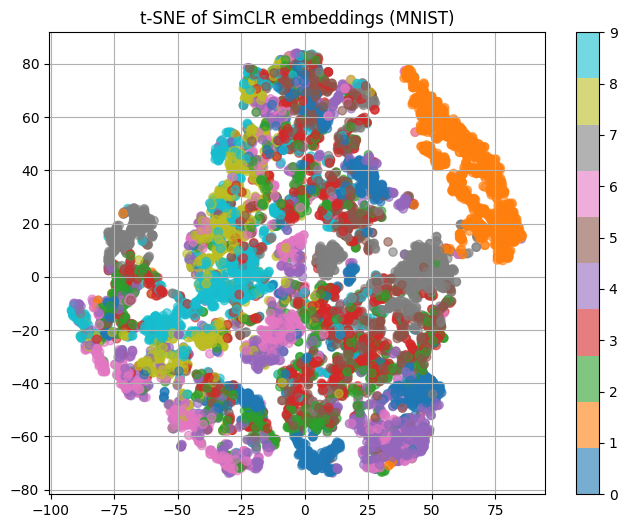

In [19]:

# ----- Embedding Visualization -----
# Extract features and apply t-SNE
features = model(x_test / 255.).numpy()
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='random', random_state=42)
embeddings_2d = tsne.fit_transform(features)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_test, cmap='tab10', alpha=0.6)
plt.colorbar(scatter, ticks=range(10))
plt.title("t-SNE of SimCLR embeddings (MNIST)")
plt.grid(True)
plt.show()


# Linear evaluation
We can also for instance now freeze the embedding, and train a linear classifier on top ("finetuning")

In [20]:
# ----- Linear Evaluation -----
# Freeze encoder, train linear classifier
frozen_encoder = tf.keras.Sequential([
    model,
    layers.Dense(64, activation='relu', trainable=False)
])
classifier = tf.keras.Sequential([
    frozen_encoder,
    layers.Dense(10, activation='softmax')
])
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
classifier.fit(x_train / 255., y_train, epochs=5, batch_size=256, validation_split=0.1)

Epoch 1/5
211/211 [==============================] - 5s 20ms/step - loss: 1.8290 - accuracy: 0.5441 - val_loss: 1.4495 - val_accuracy: 0.7417
Epoch 2/5
211/211 [==============================] - 4s 18ms/step - loss: 1.1853 - accuracy: 0.7821 - val_loss: 0.9188 - val_accuracy: 0.8472
Epoch 3/5
211/211 [==============================] - 4s 19ms/step - loss: 0.8073 - accuracy: 0.8365 - val_loss: 0.6635 - val_accuracy: 0.8672
Epoch 4/5
211/211 [==============================] - 4s 18ms/step - loss: 0.5977 - accuracy: 0.8689 - val_loss: 0.5174 - val_accuracy: 0.8810
Epoch 5/5
211/211 [==============================] - 4s 19ms/step - loss: 0.4791 - accuracy: 0.8929 - val_loss: 0.4028 - val_accuracy: 0.9087
